In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import sys
import torch
import torch.nn as nn
from hydra import compose, initialize
from sklearn.metrics import precision_recall_fscore_support
import dataframe_image as dfi
sys.path.append("../src/")
from models.lightning_modules import CNN_mel, CNN_modgd, CNN_pitch

#device config
print(torch.cuda.is_available())
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


True
2.0.0+cu117


In [2]:
# global initialization
initialize(version_base=None, config_path="../configs")
cfg = compose(config_name="config")

In [3]:
# constants
lr = cfg.training.learning_rate
num_classes = cfg.constants.num_classes
models_dir = cfg.graphs.models_dir
version = cfg.graphs.version
models_list = ["mel", "modgd", "pitch"]
aggregation_method = cfg.aggregation.method
label_map = cfg.label_map
convert_label_map = {y: x for x, y in label_map.items()}

<h2>Load test data</h2>

In [4]:
print("Load X_test and y_test")
f = open("../data/processed/X_test_mel.pkl", "rb")
X_test_mel = pickle.load(f)
f.close()
print("Mel data loaded!")

f = open("../data/processed/X_test_modgd.pkl", "rb")
X_test_modgd = pickle.load(f)
f.close()
print("Modgd data loaded!")

f = open("../data/processed/X_test_pitch.pkl", "rb")
X_test_pitch = pickle.load(f)
f.close()
print("Pitch data loaded!")

f = open("../data/processed/y_test.pkl", "rb")
y_test = pickle.load(f)
f.close()

X_test = [X_test_mel, X_test_modgd, X_test_pitch]

a = y_test
y_test = torch.zeros((len(a), num_classes))
for i in range(len(a)):
    y_test[i] = a[i][0]

Load X_test and y_test
Mel data loaded!
Modgd data loaded!
Pitch data loaded!


<h2>Load models</h2>

In [5]:
models = []
model_names = []

for root, dirs, files in os.walk(models_dir):
    files.sort()
    for file in files:
        if (file == 'cnn_mel.ckpt'):
            print('success')
            model = CNN_mel.load_from_checkpoint(os.path.join(models_dir, file), lr=lr, num_labels=num_classes)
            model_names.append(file)
            models.append(model)
        elif (file == 'cnn_modgd.ckpt'):
            model = CNN_modgd.load_from_checkpoint(os.path.join(models_dir, file), lr=lr, num_labels=num_classes)
            model_names.append(file)
            models.append(model)
        elif (file == 'cnn_pitch.ckpt'):
            model = CNN_pitch.load_from_checkpoint(os.path.join(models_dir, file), lr=lr, num_labels=num_classes)
            model_names.append(file)
            models.append(model)
num_models = len(models)
print(model_names)

success
['cnn_mel.ckpt', 'cnn_modgd.ckpt', 'cnn_pitch.ckpt']


<h3>Compute probabilities</h3>

In [6]:
def compute_probabilities(aggregation_method):
    probabilities = []

    for i in range(num_models):
        tmp_probs = []
        model = models[i]
        model.eval()
        for (key, val) in X_test[i].items():

            print(i, ":", key, "/", len(X_test[i]))

            val = val.to(device)
            
            # Model prediction
            val = val.view(val.size(0), 1, val.size(1), val.size(2))
            
            prediction = model(val)
            soft = nn.Softmax(dim=1)
            prediction = soft(prediction)

            # Aggregation
            if aggregation_method == "s1":
                prediction = torch.mean(prediction, axis = 0)
            elif aggregation_method == "s2":
                prediction = torch.sum(prediction, axis = 0)
                m = torch.max(prediction)
                prediction /= m
                
            tmp_probs.append(prediction.detach().cpu().numpy())
            
        tmp_probs = np.array(tmp_probs)
        probabilities.append(tmp_probs)

    probabilities = np.array(probabilities)

    return probabilities

In [7]:
print("Computing probabilities")

probabilities = compute_probabilities(aggregation_method)

print("Probabilities computed!")

Computing probabilities
0 : 0 / 2874
0 : 1 / 2874
0 : 2 / 2874
0 : 3 / 2874
0 : 4 / 2874
0 : 5 / 2874
0 : 6 / 2874
0 : 7 / 2874
0 : 8 / 2874
0 : 9 / 2874
0 : 10 / 2874
0 : 11 / 2874
0 : 12 / 2874
0 : 13 / 2874
0 : 14 / 2874
0 : 15 / 2874
0 : 16 / 2874
0 : 17 / 2874
0 : 18 / 2874
0 : 19 / 2874
0 : 20 / 2874
0 : 21 / 2874
0 : 22 / 2874
0 : 23 / 2874
0 : 24 / 2874
0 : 25 / 2874
0 : 26 / 2874
0 : 27 / 2874
0 : 28 / 2874
0 : 29 / 2874
0 : 30 / 2874
0 : 31 / 2874
0 : 32 / 2874
0 : 33 / 2874
0 : 34 / 2874
0 : 35 / 2874
0 : 36 / 2874
0 : 37 / 2874
0 : 38 / 2874
0 : 39 / 2874
0 : 40 / 2874
0 : 41 / 2874
0 : 42 / 2874
0 : 43 / 2874
0 : 44 / 2874
0 : 45 / 2874
0 : 46 / 2874
0 : 47 / 2874
0 : 48 / 2874
0 : 49 / 2874
0 : 50 / 2874
0 : 51 / 2874
0 : 52 / 2874
0 : 53 / 2874
0 : 54 / 2874
0 : 55 / 2874
0 : 56 / 2874
0 : 57 / 2874
0 : 58 / 2874
0 : 59 / 2874
0 : 60 / 2874
0 : 61 / 2874
0 : 62 / 2874
0 : 63 / 2874
0 : 64 / 2874
0 : 65 / 2874
0 : 66 / 2874
0 : 67 / 2874
0 : 68 / 2874
0 : 69 / 2874
0 : 70

In [8]:
def calculate_acc(y1, y2):
    ret = 0
    for i, _ in enumerate(y1):
        ret += int(y1[i] == y2[i])
    ret /= len(y1)
    return ret

def calculate_scores(thetas):

    accuracy = 0.0

    y_pred = np.zeros((probabilities.shape[1], probabilities.shape[2]))

    acc_per_instr = []

    for k in range(num_classes):

        pred = [(np.array(probabilities[id, :, k]) - theta) for id, theta in enumerate(thetas[k])]

        for i, _ in enumerate(pred):
            pred[i][pred[i] > 0] = 1
            pred[i][pred[i] <= 0] = 0

        for i, _ in enumerate(thetas[k]):
            if thetas[k][i] == -1:
                pred[i] = np.ones(pred[i].shape)

        pred = np.multiply(np.multiply(pred[0], pred[1]), pred[2])

        y_pred[:, k] = pred

        accuracy += calculate_acc(pred, y_test[:, k])

        acc_per_instr.append(calculate_acc(pred, y_test[:, k]))

    accuracy /= num_classes

    micro_prec, micro_rec, micro_f1, _ = precision_recall_fscore_support(y_test, y_pred, average="micro")
    macro_prec, macro_rec, macro_f1, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")

    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

    return accuracy, micro_f1, macro_f1, f1, acc_per_instr



<h3>Comparison of mel, mel+modgd and mel+modgd+pitch models according to metrics: f1, precision, recall and accuracy</h3>

In [9]:
fusion_thetas_mel_modgd_pitch = np.load("../src/fusion/fusion_thresholds_mel_modgd_pitch_acc.npy")
fusion_thetas_mel_modgd = np.load("../src/fusion/fusion_thresholds_mel_modgd_acc.npy")
fusion_thetas_mel = np.load("../src/fusion/fusion_thresholds_mel_acc.npy")

scores_mel = calculate_scores(fusion_thetas_mel)
scores_mel_modgd = calculate_scores(fusion_thetas_mel_modgd)
scores_mel_modgd_pitch = calculate_scores(fusion_thetas_mel_modgd_pitch)

metric = {
    0: "accuracy",
    1: "micro_f1",
    2: "macro_f1",
    3: "f1_per_instr",
    4: "acc_per_instr"
}

ids = [1, 2, 0]
data = []
for id in ids:
    data.append(["mel", metric[id], scores_mel[id]])
    data.append(["mel+modgd", metric[id], scores_mel_modgd[id]])
    data.append(["mel+modgd+pitch", metric[id], scores_mel_modgd_pitch[id]])

df = pd.DataFrame(data, columns=["model", "metric", "value"])

print(df)

/home/marmest/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marmest/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


             model    metric     value
0              mel  micro_f1  0.611501
1        mel+modgd  micro_f1  0.627807
2  mel+modgd+pitch  micro_f1  0.638148
3              mel  macro_f1  0.454088
4        mel+modgd  macro_f1  0.486875
5  mel+modgd+pitch  macro_f1  0.501499
6              mel  accuracy  0.900202
7        mel+modgd  accuracy  0.906687
8  mel+modgd+pitch  accuracy  0.909028


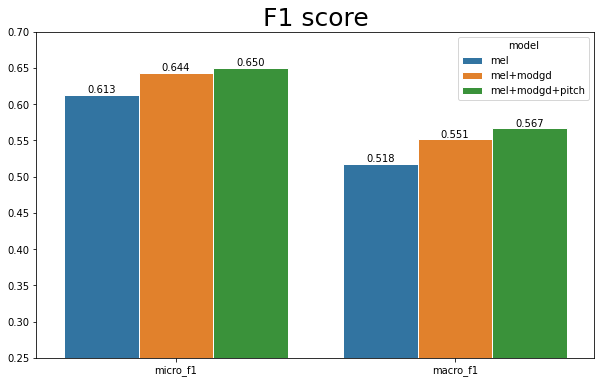

In [96]:
fusion_thetas_mel_modgd_pitch = np.load("../src/fusion/fusion_thresholds_mel_modgd_pitch_f1.npy")
fusion_thetas_mel_modgd = np.load("../src/fusion/fusion_thresholds_mel_modgd_f1.npy")
fusion_thetas_mel = np.load("../src/fusion/fusion_thresholds_mel_f1.npy")

scores_mel = calculate_scores(fusion_thetas_mel)
scores_mel_modgd = calculate_scores(fusion_thetas_mel_modgd)
scores_mel_modgd_pitch = calculate_scores(fusion_thetas_mel_modgd_pitch)

ids = [1, 2, 0]
data = []
for id in ids:
    data.append(["mel", metric[id], scores_mel[id]])
    data.append(["mel+modgd", metric[id], scores_mel_modgd[id]])
    data.append(["mel+modgd+pitch", metric[id], scores_mel_modgd_pitch[id]])

df = pd.DataFrame(data, columns=["model", "metric", "value"])

plt.figure(figsize=(10,6))
barplot = sns.barplot(data=df[df["metric"].isin(["micro_f1", "macro_f1"])], x="metric", y="value", hue="model", edgecolor="white")
barplot.set_ylim(0.25, 0.7)
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.3f')
barplot.set(xlabel='', ylabel='')
barplot.set_title("F1 score", fontdict={'size': 25})
plt.savefig('../pictures/f1_barplot.png')
plt.show()

/home/marmest/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marmest/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


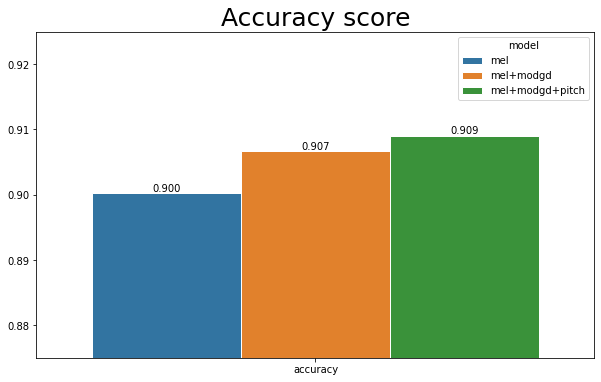

In [11]:
fusion_thetas_mel_modgd_pitch = np.load("../src/fusion/fusion_thresholds_mel_modgd_pitch_acc.npy")
fusion_thetas_mel_modgd = np.load("../src/fusion/fusion_thresholds_mel_modgd_acc.npy")
fusion_thetas_mel = np.load("../src/fusion/fusion_thresholds_mel_acc.npy")

scores_mel = calculate_scores(fusion_thetas_mel)
scores_mel_modgd = calculate_scores(fusion_thetas_mel_modgd)
scores_mel_modgd_pitch = calculate_scores(fusion_thetas_mel_modgd_pitch)

ids = [1, 2, 0]
data = []
for id in ids:
    data.append(["mel", metric[id], scores_mel[id]])
    data.append(["mel+modgd", metric[id], scores_mel_modgd[id]])
    data.append(["mel+modgd+pitch", metric[id], scores_mel_modgd_pitch[id]])

df = pd.DataFrame(data, columns=["model", "metric", "value"])

plt.figure(figsize=(10,6))
barplot = sns.barplot(data=df[df["metric"].isin(["accuracy"])], x="metric", y="value", hue="model", edgecolor="white")
barplot.set_ylim(0.875, 0.925)
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.3f')
barplot.set(xlabel='', ylabel='')
barplot.set_title("Accuracy score", fontdict={'size': 25})
plt.savefig('../pictures/accuracy_barplot.png')
plt.show()

<h3>Comparison of f1 score and accuracy score per instrument</h3>

In [12]:
fusion_thetas_mel_modgd_pitch = np.load("../src/fusion/fusion_thresholds_mel_modgd_pitch_f1.npy")
fusion_thetas_mel_modgd = np.load("../src/fusion/fusion_thresholds_mel_modgd_f1.npy")
fusion_thetas_mel = np.load("../src/fusion/fusion_thresholds_mel_f1.npy")

scores_mel = calculate_scores(fusion_thetas_mel)
scores_mel_modgd = calculate_scores(fusion_thetas_mel_modgd)
scores_mel_modgd_pitch = calculate_scores(fusion_thetas_mel_modgd_pitch)

ids = [3, 4]
data = []
for id in ids:
    for instr_id in range(num_classes):
        data.append(["mel", metric[id], convert_label_map[instr_id], scores_mel[id][instr_id]])
        data.append(["mel+modgd", metric[id], convert_label_map[instr_id], scores_mel_modgd[id][instr_id]])
        data.append(["mel+modgd+pitch", metric[id], convert_label_map[instr_id], scores_mel_modgd_pitch[id][instr_id]])

df = pd.DataFrame(data, columns=["model", "metric", "instrument", "value"])

table = df[df["metric"] == "f1_per_instr"]

table = pd.pivot_table(table, 
                             index=['instrument'], 
                             columns=['model'], 
                             values='value')


# reset the index to make 'instrument' a column instead of index
#pivot_table = pivot_table.reset_index()

table = table.reset_index()

# calculate the percentage of difference between the second and third columns
table['percentage_diff'] = 100 * (table['mel+modgd+pitch'] - table['mel+modgd']) / table['mel+modgd']

print(table)

dfi.export(table, '../pictures/f1_per_instrument_table.png')

model instrument       mel  mel+modgd  mel+modgd+pitch  percentage_diff
0            cel  0.296703   0.324607         0.354430         9.187423
1            cla  0.152381   0.213483         0.255319        19.596865
2            flu  0.468571   0.557864         0.568915         1.981032
3            gac  0.506726   0.518033         0.534989         3.273138
4            gel  0.646182   0.685475         0.686254         0.113569
5            org  0.380410   0.414482         0.414853         0.089474
6            pia  0.602546   0.610819         0.614958         0.677759
7            sax  0.632948   0.658993         0.707646         7.382990
8            tru  0.565476   0.596273         0.605096         1.479565
9            vio  0.575000   0.610644         0.611898         0.205317
10           voi  0.870728   0.875494         0.878365         0.327910


In [13]:
fusion_thetas_mel_modgd_pitch = np.load("../src/fusion/fusion_thresholds_mel_modgd_pitch_acc.npy")
fusion_thetas_mel_modgd = np.load("../src/fusion/fusion_thresholds_mel_modgd_acc.npy")
fusion_thetas_mel = np.load("../src/fusion/fusion_thresholds_mel_acc.npy")

scores_mel = calculate_scores(fusion_thetas_mel)
scores_mel_modgd = calculate_scores(fusion_thetas_mel_modgd)
scores_mel_modgd_pitch = calculate_scores(fusion_thetas_mel_modgd_pitch)

ids = [3, 4]
data = []
for id in ids:
    for instr_id in range(num_classes):
        data.append(["mel", metric[id], convert_label_map[instr_id], scores_mel[id][instr_id]])
        data.append(["mel+modgd", metric[id], convert_label_map[instr_id], scores_mel_modgd[id][instr_id]])
        data.append(["mel+modgd+pitch", metric[id], convert_label_map[instr_id], scores_mel_modgd_pitch[id][instr_id]])

df = pd.DataFrame(data, columns=["model", "metric", "instrument", "value"])

table = df[df["metric"] == "acc_per_instr"]

table = pd.pivot_table(table, 
                             index=['instrument'], 
                             columns=['model'], 
                             values='value')


# reset the index to make 'instrument' a column instead of index
#pivot_table = pivot_table.reset_index()

table = table.reset_index()

# calculate the percentage of difference between the second and third columns
table['percentage_diff'] = 100 * (table['mel+modgd+pitch'] - table['mel+modgd']) / table['mel+modgd']

print(table)

dfi.export(table, '../pictures/accuracy_per_instrument_table.png')

/home/marmest/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marmest/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model instrument       mel  mel+modgd  mel+modgd+pitch  percentage_diff
0            cel  0.962770   0.963814         0.965553         0.180505
1            cla  0.978427   0.978427         0.978775         0.035562
2            flu  0.955463   0.955811         0.957203         0.145613
3            gac  0.862909   0.865692         0.869868         0.482315
4            gel  0.772095   0.805846         0.805498        -0.043178
5            org  0.889701   0.892136         0.892484         0.039002
6            pia  0.753653   0.756437         0.764440         1.057958
7            sax  0.914753   0.929715         0.938065         0.898204
8            tru  0.957550   0.959290         0.959638         0.036271
9            vio  0.945372   0.951287         0.952331         0.109729
10           voi  0.909534   0.915101         0.915449         0.038023


<h3>Thresholds analysis</h3>

In [94]:
def calculate_acc(y1, y2):
    ret = 0
    for i, _ in enumerate(y1):
        ret += int(y1[i] == y2[i])
    ret /= len(y1)
    return ret

def calculate_f1(y1, y2):
    tp = 0
    fp = 0
    fn = 0
    for i, _ in enumerate(y1):
        if y1[i] == 1 and y2[i] == 1:
            tp += 1
        elif y1[i] == 1 and y2[i] == 0:
            fp += 1
        elif y1[i] == 0 and y2[i] == 1:
            fn += 1
    f1 = (2 * tp) / (2 * tp + fp + fn)
    return f1

model_names = ["Mel", "Modgd", "Pitch"]

def threshold_swipe(thetas, k, mod, metric):

    threshold_graph = []
    
    for x in np.linspace(0, 1, 500):

        thetas[k][mod] = x

        pred = [(np.array(probabilities[id, :, k]) - theta) for id, theta in enumerate(thetas[k])]

        for i, _ in enumerate(pred):
            pred[i][pred[i] > 0] = 1
            pred[i][pred[i] <= 0] = 0

        for i, _ in enumerate(thetas[k]):
            if thetas[k][i] == -1:
                pred[i] = np.ones(pred[i].shape)

        pred = np.multiply(np.multiply(pred[0], pred[1]), pred[2])

        if metric == "accuracy":
            threshold_graph.append([x, calculate_acc(pred, y_test[:, k])])
        elif metric == "f1 score":
            threshold_graph.append([x, calculate_f1(pred, y_test[:, k])])
    plt.figure()
    plt.title(convert_label_map[k].capitalize() + " " + metric + " change with " + model_names[mod] + " threshold", fontsize=15)
    plt.plot([tg[0] for tg in   threshold_graph], [tg[1] for tg in threshold_graph])
    if metric == "accuracy":
        plt.savefig("../pictures/threshold_change_" + convert_label_map[k] + "_acc_" + model_names[mod].lower() + ".png")
    elif metric == "f1 score":
        plt.savefig("../pictures/threshold_change_" + convert_label_map[k] + "_f1_" + model_names[mod].lower() + ".png")
    plt.show()

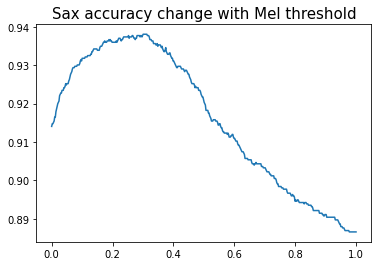

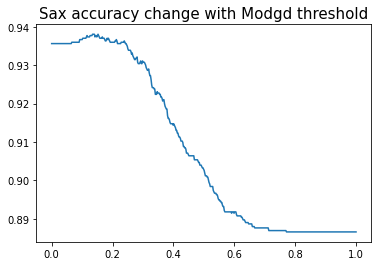

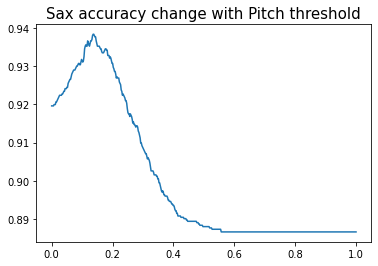

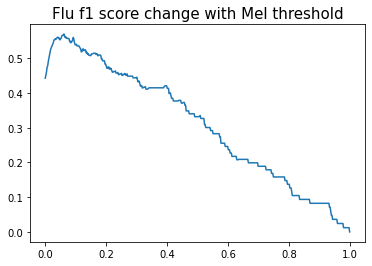

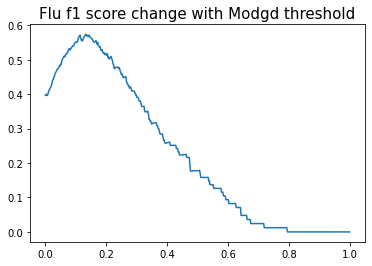

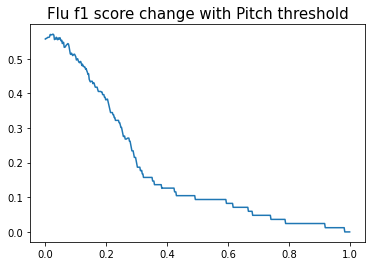

In [95]:
fusion_thetas_mel_modgd_pitch_acc = np.load("../src/fusion/fusion_thresholds_mel_modgd_pitch_acc.npy")
fusion_thetas_mel_modgd_pitch_f1 = np.load("../src/fusion/fusion_thresholds_mel_modgd_pitch_f1.npy")

for i in [0, 1, 2]:
    threshold_swipe(fusion_thetas_mel_modgd_pitch_acc.copy(), 7, i, "accuracy")
# 7
for i in [0, 1, 2]:
    threshold_swipe(fusion_thetas_mel_modgd_pitch_f1.copy(), 2, i, "f1 score")
# 2